In [29]:
import shap
import pandas as pd
import numpy as np
from scipy.stats import uniform
from pygam import LogisticGAM
from scipy.stats import loguniform
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_recall_curve,
    roc_auc_score,
    average_precision_score,
)
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

import sys
import os
import warnings


if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore"

In [2]:
path = "https://raw.githubusercontent.com/nogibjj/IDS705_FinalProject_Lemur_Team/main/01_clean_data/adult_ohe.csv"

adult_ohe = pd.read_csv(path)

X = adult_ohe.drop(columns=["income"])
y = adult_ohe["income"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [3]:
param_dist = {
    "lam": uniform(0.1, 0.9),  # default: 0.6
    "n_splines": list(range(5, 51)),  # default: 20
    "max_iter": list(range(50, 201)),  # default: 100
    "tol": uniform(0.0001, 0.001),  # default: 0.0001
}

clf = LogisticGAM()

random_search = RandomizedSearchCV(
    clf,
    param_distributions=param_dist,
    n_iter=10,
    cv=5,
    scoring="roc_auc",
    random_state=42,
)

random_search.fit(X_train, y_train)

best_params = random_search.best_params_
best_model = random_search.best_estimator_
best_params

did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge


{'lam': 0.4370861069626263,
 'max_iter': 142,
 'n_splines': 19,
 'tol': 0.0008319939418114052}

In [35]:
y_pred = best_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
y_pred_proba = best_model.predict_proba(X_test)  # [:, 1]
auc_roc = roc_auc_score(y_test, y_pred_proba)
auc_pr = average_precision_score(y_test, y_pred_proba)

# Max F1
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
f1_scores = 2 * (precision * recall) / (precision + recall)
max_f1_index = np.argmax(f1_scores)
max_threshold = thresholds[max_f1_index]
max_f1 = f1_scores[max_f1_index]

print(f"Max F1: {max_f1:.3f} at threshold {max_threshold:.3f}")
print(f"AUC - ROC: {auc_roc:.3f}")
print(f"AUC - PR: {auc_pr:.3f}")
print(f"Accuracy: {accuracy:.3f}")

Max F1: 0.706 at threshold 0.341
AUC - ROC: 0.913
AUC - PR: 0.791
Accuracy: 0.858


In [5]:
# Result for AUC PR curves
results = pd.DataFrame({"score": y_pred_proba})
results.index.name = "id"
results.to_csv("../40_results/gam_prob.csv")

### SHAP

In [6]:
def f(x):
    return best_model.predict_proba(x)  # [:, 1]


med = X_train.median().values.reshape((1, X_train.shape[1]))

explainer = shap.Explainer(f, med)
shap_values = explainer(X_test)

PermutationExplainer explainer: 9770it [47:48,  3.40it/s]                           


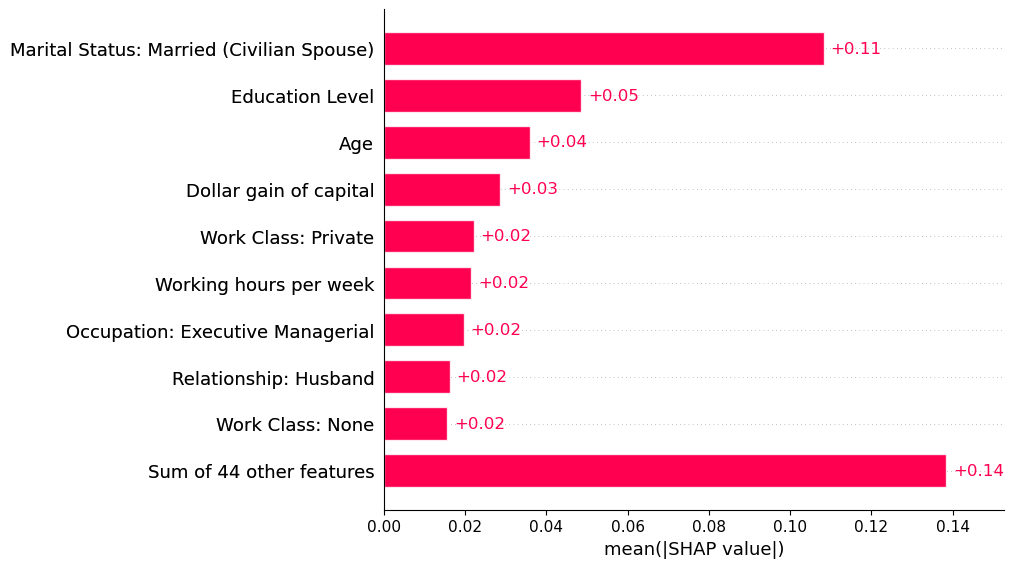

In [36]:
shap.plots.bar(shap_values)

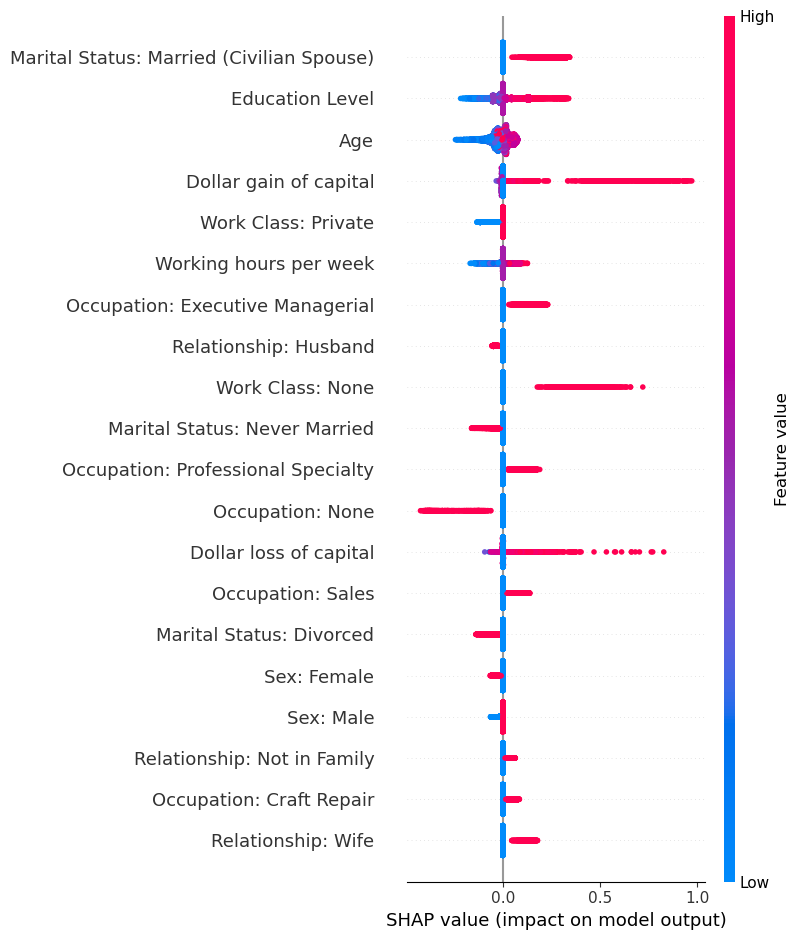

In [37]:
shap.summary_plot(shap_values, X_test)

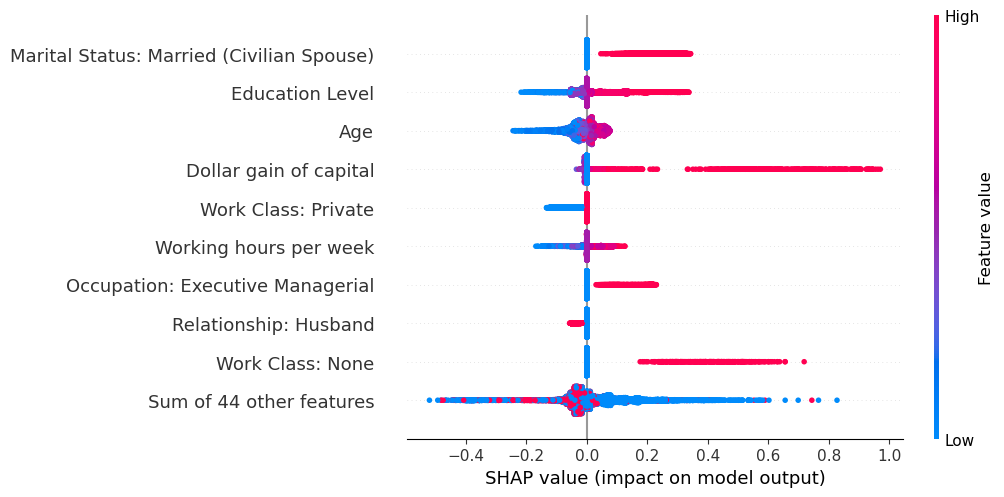

In [8]:
shap.plots.beeswarm(shap_values)

In [39]:
X.shape

(48842, 53)

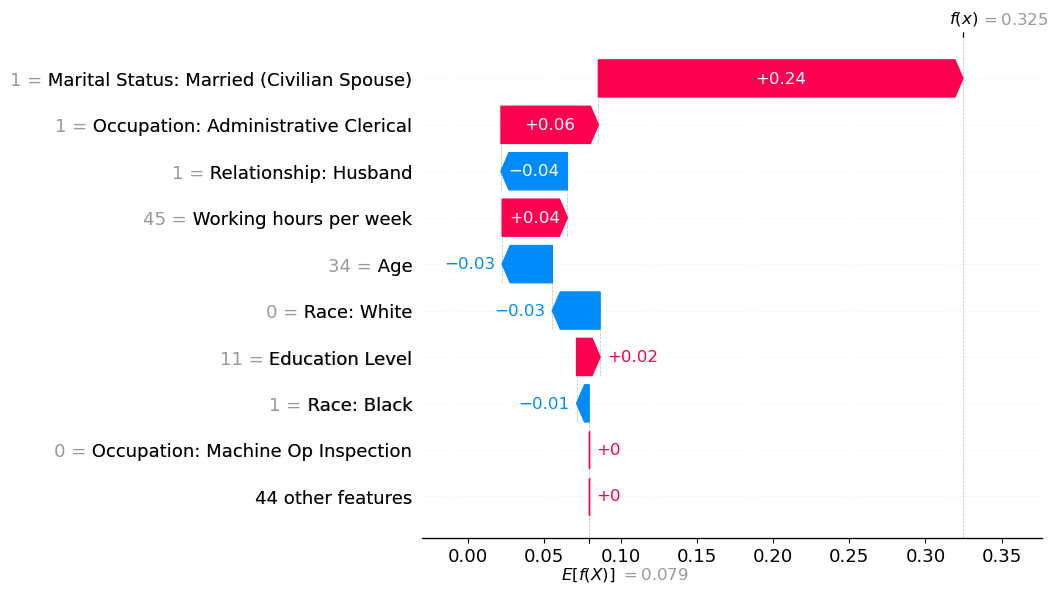

In [9]:
shap.plots.waterfall(shap_values[11])

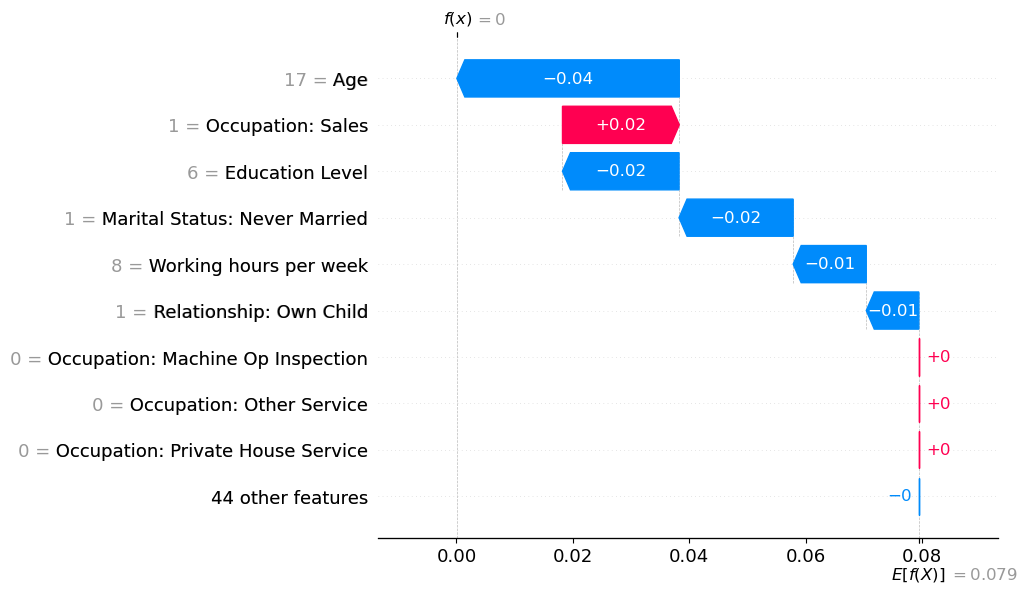

In [45]:
shap.plots.waterfall(shap_values[2233])

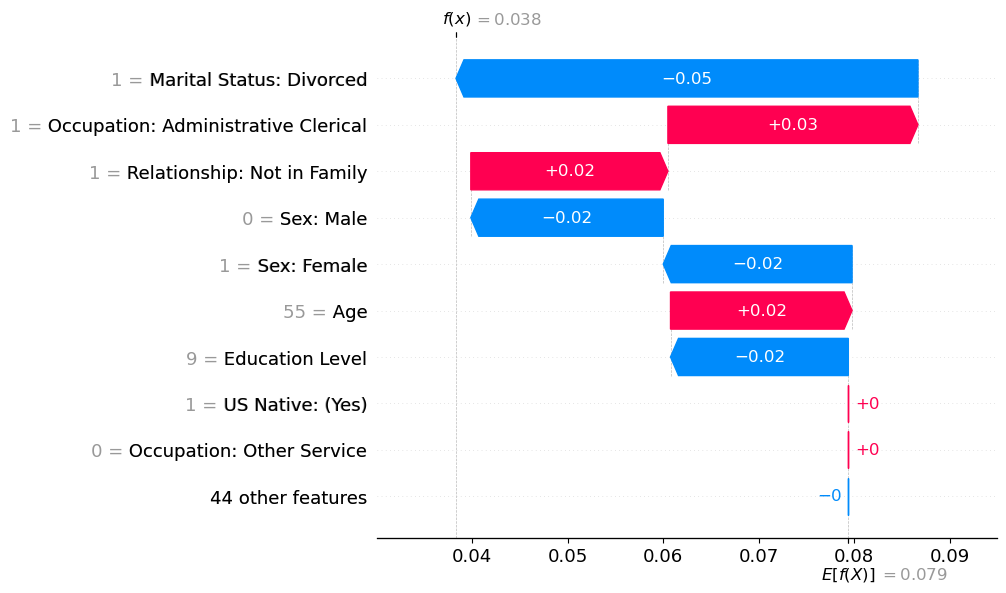

In [41]:
shap.plots.waterfall(shap_values[5478])

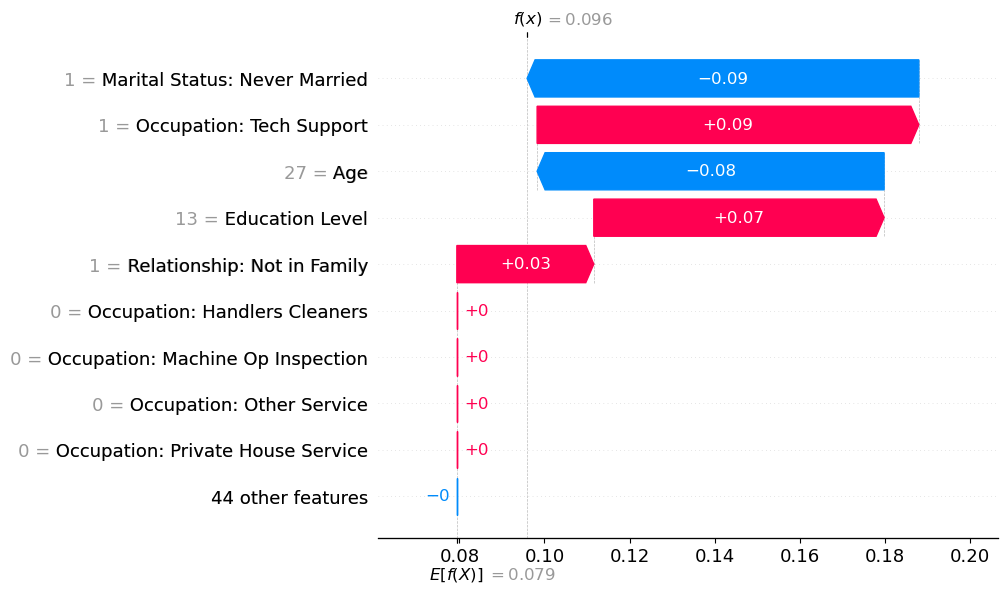

In [46]:
shap.plots.waterfall(shap_values[6740])

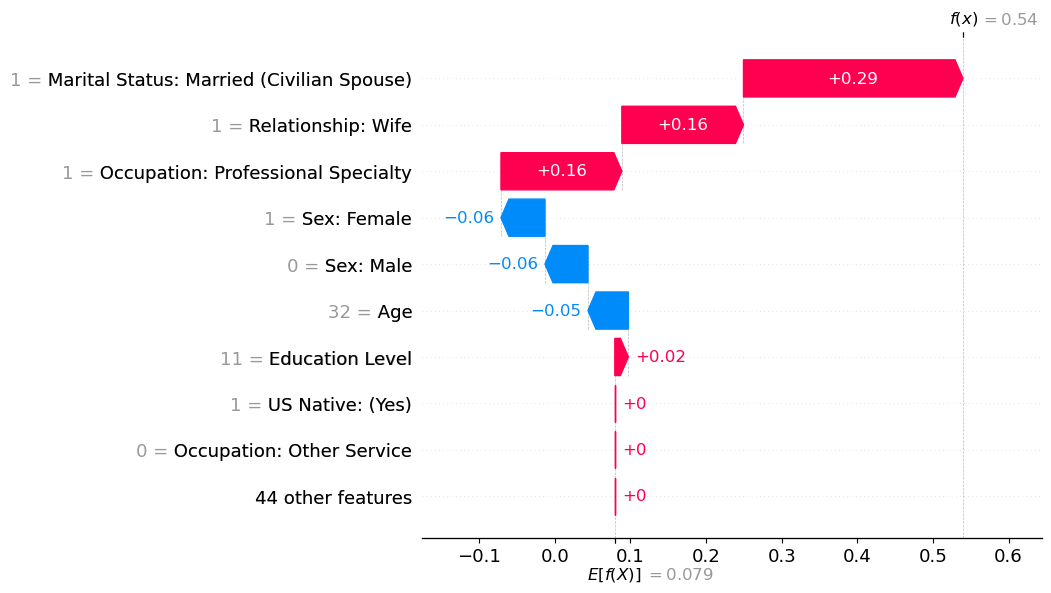

In [43]:
shap.plots.waterfall(shap_values[8901])